# Sep 27, 2025: find effective number of partition modes

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
ROI_RESULTS_path_boot = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}-boot'
)
GRAPH_path_boot = f'{ROI_RESULTS_path_boot}/graphs'
os.system(f'mkdir -p {GRAPH_path_boot}')
SBM_path_boot = f'{ROI_RESULTS_path_boot}/model-fits'
os.system(f'mkdir -p {SBM_path_boot}')
DIAG_path_boot = f'{ROI_RESULTS_path_boot}/diagnostics'
os.system(f'mkdir -p {DIAG_path_boot}')
ESTIM_path_boot = f'{ROI_RESULTS_path_boot}/estimates'
os.system(f'mkdir -p {ESTIM_path_boot}/individual')
os.system(f'mkdir -p {ESTIM_path_boot}/group')

0

In [10]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

load membership matrices

In [11]:
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-SLC01/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
grp_df = []
for file in indiv_files:
    with open(file, 'rb') as f:
        df = pickle.load(f)
    grp_df += [df]

In [12]:
boot_files = sorted(glob.glob(f'{ESTIM_path_boot}/individual/boot-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
boots_df = []
for file in tqdm(boot_files):
    with open(file, 'rb') as f:
        df = pickle.load(f)
    boots_df += [df]

100%|██████████| 110/110 [00:01<00:00, 70.25it/s]


In [13]:
pis_df = pd.concat(grp_df + boots_df).reset_index(drop=True)
# pis_df

In [14]:
def make_same_shape(Ms: list):
    num_rois = Ms[0].shape[0]
    num_comms = [M.shape[-1] for M in Ms]
    max_comms = np.max(num_comms)
    Rs = np.zeros((len(Ms), num_rois, max_comms))
    for idx, M in enumerate(Ms):
        Rs[idx, :, :M.shape[-1]] = M
    Rs = [Rs[idx, :, :] for idx in range(Rs.shape[0])]
    return Rs

In [15]:
cols = [c for c in pis_df.columns if 'pi' in c]

In [16]:
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].apply(lambda pis: make_same_shape(pis.to_list())),
    ],
    axis=1
)

In [17]:
pis_df

,sub,sbm,omega,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,grp,sbm-nd-h,0.257972,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9496124031007752, 0.0, 0.0, 0.0, 0.0503875...","[[0.26990405650233273, 0.6440288789416553, 0.0...","[[0.9201526698804413, 0.06128537650572014, 0.0...","[[0.9878395515527075, 0.009976689198605605, 0....","[[0.9957242760577405, 0.004275723942259544, 0....","[[0.997149517371827, 0.0028504826281730293, 0....","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999..."
1,grp,sbm-nd-h,0.141756,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9014084507042254, 0.0, 0.03521126760563380...","[[0.2577782484379964, 0.6056505825165969, 0.10...","[[0.9229028897536316, 0.04418924874364539, 0.0...","[[0.9832180171575026, 0.009469124730781155, 0....","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0018282145279290526, 0....","[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0...."
2,grp,sbm-nd-h,0.126375,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9603174603174603, 0.0, 0.02380952380952380...","[[0.062295288485764676, 0.837962962962963, 0.0...","[[0.990532053055227, 0.0034393706396990465, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
3,grp,sbm-nd-h,0.121384,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.15702479338842976, 0.768595041322314, 0.06...","[[0.8881112654215585, 0.10046874960473759, 0.0...","[[0.998572501878287, 0.0, 0.001427498121712997...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
4,grp,sbm-nd-h,0.076945,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.974025974025974, 0.0, 0.025974025974025976...","[[0.6071850227694383, 0.27862602196163366, 0.0...","[[0.9291409601437918, 0.015660401422622795, 0....","[[0.9874163597969866, 0.0046981204267868395, 0...","[[0.9905484400815112, 0.00156604014226228, 0.0...","[[0.9921144802237735, 0.0, 0.00788551977622647...","[[0.9921144802237735, 0.00788551977622647, 0.0...","[[0.9921144802237735, 0.00788551977622647, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,89,sbm-nd-h,0.040787,"[[0.975609756097561, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8958754709498316, 0.023795359904818562, 0....","[[0.0808199036613937, 0.8079089746876055, 0.08...","[[0.9531361388326043, 0.04109101090586787, 0.0...","[[1.0000000000000002, 0.0, 0.0, 0.0], [0.99999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999..."
1272,89,sbm-nd-h,0.038413,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.42105263157894735, 0.0, 0.5789473684210527...","[[0.060403200984918436, 0.9013542628501078, 0....","[[0.9708477102266285, 0.029152289773371563, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999..."
1273,89,sbm-nd-h,0.030960,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.12903225806451613, 0.0, 0.8709677419354839...","[[0.008324661810613945, 0.9146722164412071, 0....","[[0.9990750375765985, 0.0, 0.00092496242340154...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 

In [18]:
def get_soft_estim_df(estim_df: pd.DataFrame):
    soft_estim_df = []
    for sub, group in estim_df.groupby('sub'):
        omegas = group['omega']
        dct = {'sub':[sub], 'sbm':[SBM]}
        for col in cols:
            X = group[col].to_list()
            soft_X = np.average(X, axis=0, weights=omegas)
            dct[col] = [soft_X]
        soft_estim_df += [pd.DataFrame(dct)]
    soft_estim_df = pd.concat(soft_estim_df).reset_index(drop=True)
    return soft_estim_df

In [19]:
soft_pis_df = get_soft_estim_df(pis_df)
soft_pis_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,00,sbm-nd-h,"[[0.9889291029457001, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8716512643549744, 0.006910359661301418, 0....","[[0.16258106453977905, 0.7934859893876889, 0.0...","[[0.9552860843637466, 0.031449391596061735, 0....","[[0.9937854604168056, 0.003315275054366852, 0....","[[0.9989410413627211, 0.0, 0.00105895863727896...","[[0.9995975091711569, 0.0, 0.00040249082884330...","[[0.9997354705533407, 0.00026452944665935084, ...","[[1.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0...."
1,01,sbm-nd-h,"[[0.975, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.09318055555555556, 0.10209166666666666, 0....","[[0.05296368998833612, 0.9156374031860899, 0.0...","[[0.9829553396931596, 0.01238385558786667, 0.0...","[[0.9987342000836323, 0.0010539451564141847, 0...","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0....","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0....","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0....","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0...."
2,02,sbm-nd-h,"[[0.9980012129746905, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.030883720675270784, 0.0, 0.927180282255083...","[[0.043664179946214424, 0.941400691672547, 0.0...","[[0.992144868621328, 0.003886786619224509, 0.0...","[[0.9978603643025216, 0.0008262368171808249, 0...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
3,03,sbm-nd-h,"[[0.2037765811965812, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.115809705436111, 0.0019043415637860085, 0....","[[0.05935123780200156, 0.860974596588191, 0.06...","[[0.9543664264167261, 0.04283992724197806, 0.0...","[[0.993072645482781, 0.006487205259558541, 0.0...","[[0.9990997027926715, 0.0009002972073286832, 0...","[[1.0000000000000002, 0.0, 0.0], [1.0000000000...","[[1.0000000000000002, 0.0, 0.0], [1.0000000000...","[[1.0000000000000002, 0.0, 0.0], [1.0000000000..."
4,04,sbm-nd-h,"[[0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.8839876896551724, 0.000424, 0.064764011494...","[[0.1361524579629647, 0.6387141699100736, 0.01...","[[0.9635657976870232, 0.029418713066793393, 0....","[[0.9915382342460624, 0.006642935208630766, 0....","[[0.9983166809488209, 0.0014234861161351643, 0...","[[0.9995255046279549, 0.0004744953720450547, 0...","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0....","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0...."
...,...,...,...,...,...,...,...,...,...,...,...
106,84,sbm-nd-h,"[[0.9467859298379986, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.14320392160729362, 0.005911994233150053, 0...","[[0.051711404789508045, 0.9219815348819543, 0....","[[0.9500650034966606, 0.04528723649830124, 0.0...","[[0.9869806767758922, 0.012825791323104588, 0....","[[0.9952848525605956, 0.004521615538401171, 0....","[[0.9982114716762623, 0.00163736380955704, 0.0...","[[0.9991813180952215, 0.0, 0.00081868190477852...","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0...."
107,85,sbm-nd-h,"[[0.7523710403669525, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9090278043555757, 6.669014464337269e-05, 0...","[[0.130745105318791, 0.8293108014072729, 0.016...","[[0.9629858046212519, 0.02190688339294367, 0.0...","[[0.9912238767567648, 0.00614705575033937, 0.0...","[[0.9991084844324997, 0.00012994119781324257, ...","[[0.9998700588021867, 0.00012994119781324257, ...","[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0....","[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0...."
108,87,sbm-nd-h,"[[0.9559742803455985, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6226689394092533, 0.07160675646419763, 0.2...","[[0.0671664480523482, 0.8878550819562366, 0.00...","[[0.9747901020531454, 0.01931813175485974, 0.0...","[[0.9965813420714152, 0.002528565069830963, 0....","[[0.9994826847233887, 0.00039715872587803167, ...","[[0.9999999999999997, 0.0, 0.0], [0.9999999999...","[[0.9999999999999997, 0.0, 0.0], [0.9999999999...","[[0.99999999999

effective number of partition modes

In [20]:
def eff_num_modes(x: np.array):
    E = np.exp(stats.entropy(x, ))
    return E

In [21]:
result = pis_df.groupby('sub')['omega'].apply(eff_num_modes).reset_index()
result['eff_num_modes'] = result['omega']
result = result.drop(['omega'], axis=1)
result

,sub,eff_num_modes
0,00,23.124534
1,01,1.000000
2,02,7.458609
3,03,9.691693
4,04,1.000000
...,...,...
106,84,11.944943
107,85,11.891270
108,87,9.016974
109,89,8.528506


In [22]:
soft_pis_df = pd.concat(
    [
        soft_pis_df[['sub', 'sbm']],
        result['eff_num_modes'],
        soft_pis_df[cols],
    ],
    axis=1,
)

In [23]:
soft_pis_df

,sub,sbm,eff_num_modes,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,00,sbm-nd-h,23.124534,"[[0.9889291029457001, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8716512643549744, 0.006910359661301418, 0....","[[0.16258106453977905, 0.7934859893876889, 0.0...","[[0.9552860843637466, 0.031449391596061735, 0....","[[0.9937854604168056, 0.003315275054366852, 0....","[[0.9989410413627211, 0.0, 0.00105895863727896...","[[0.9995975091711569, 0.0, 0.00040249082884330...","[[0.9997354705533407, 0.00026452944665935084, ...","[[1.0, 0.0, 0.0], [1.0000000000000002, 0.0, 0...."
1,01,sbm-nd-h,1.000000,"[[0.975, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.09318055555555556, 0.10209166666666666, 0....","[[0.05296368998833612, 0.9156374031860899, 0.0...","[[0.9829553396931596, 0.01238385558786667, 0.0...","[[0.9987342000836323, 0.0010539451564141847, 0...","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0....","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0....","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0....","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0...."
2,02,sbm-nd-h,7.458609,"[[0.9980012129746905, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.030883720675270784, 0.0, 0.927180282255083...","[[0.043664179946214424, 0.941400691672547, 0.0...","[[0.992144868621328, 0.003886786619224509, 0.0...","[[0.9978603643025216, 0.0008262368171808249, 0...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
3,03,sbm-nd-h,9.691693,"[[0.2037765811965812, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.115809705436111, 0.0019043415637860085, 0....","[[0.05935123780200156, 0.860974596588191, 0.06...","[[0.9543664264167261, 0.04283992724197806, 0.0...","[[0.993072645482781, 0.006487205259558541, 0.0...","[[0.9990997027926715, 0.0009002972073286832, 0...","[[1.0000000000000002, 0.0, 0.0], [1.0000000000...","[[1.0000000000000002, 0.0, 0.0], [1.0000000000...","[[1.0000000000000002, 0.0, 0.0], [1.0000000000..."
4,04,sbm-nd-h,1.000000,"[[0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.8839876896551724, 0.000424, 0.064764011494...","[[0.1361524579629647, 0.6387141699100736, 0.01...","[[0.9635657976870232, 0.029418713066793393, 0....","[[0.9915382342460624, 0.006642935208630766, 0....","[[0.9983166809488209, 0.0014234861161351643, 0...","[[0.9995255046279549, 0.0004744953720450547, 0...","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0....","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
106,84,sbm-nd-h,11.944943,"[[0.9467859298379986, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.14320392160729362, 0.005911994233150053, 0...","[[0.051711404789508045, 0.9219815348819543, 0....","[[0.9500650034966606, 0.04528723649830124, 0.0...","[[0.9869806767758922, 0.012825791323104588, 0....","[[0.9952848525605956, 0.004521615538401171, 0....","[[0.9982114716762623, 0.00163736380955704, 0.0...","[[0.9991813180952215, 0.0, 0.00081868190477852...","[[0.9999999999999999, 0.0, 0.0], [1.0, 0.0, 0...."
107,85,sbm-nd-h,11.891270,"[[0.7523710403669525, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9090278043555757, 6.669014464337269e-05, 0...","[[0.130745105318791, 0.8293108014072729, 0.016...","[[0.9629858046212519, 0.02190688339294367, 0.0...","[[0.9912238767567648, 0.00614705575033937, 0.0...","[[0.9991084844324997, 0.00012994119781324257, ...","[[0.9998700588021867, 0.00012994119781324257, ...","[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0....","[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0...."
108,87,sbm-nd-h,9.016974,"[[0.9559742803455985, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6226689394092533, 0.07160675646419763, 0.2...","[[0.0671664480523482, 0.8878550819562366, 0.00...","[[0.9747901020531454, 0.01931813175485974, 0.0...","[[0.9965813420714152, 0.002528565069830963, 0....","[[0.9994826847233887, 0.00039715872587803167, ...","[[0.9999999999999997, 0.0,

[Text(0, 0.5, ''), Text(0.5, 0, '')]

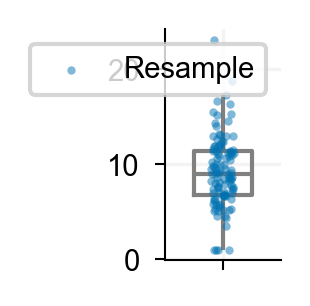

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(0.5, 1), dpi=300)

sns.stripplot(
    data=soft_pis_df,
    y='eff_num_modes',
    ax=ax,
    size=2,
    alpha=0.5,
    jitter=True,
    label='Resample',
)

sns.boxplot(
    data=soft_pis_df,
    y='eff_num_modes',
    ax=ax,
    color='grey',
    fill=False,
    width=0.5,
    # whis=0,
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.despine(ax=ax)
ax.grid(alpha=0.15)
ax.set(ylabel='', xlabel='')

In [25]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/desc-eff-num-modes.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/desc-eff-num-modes.png', transparent=True, dpi=300, bbox_inches='tight')

In [26]:
with open(f'{folder}/desc-eff-num-modes.pkl', 'wb') as f:
    pickle.dump(result, f)

omegas plot

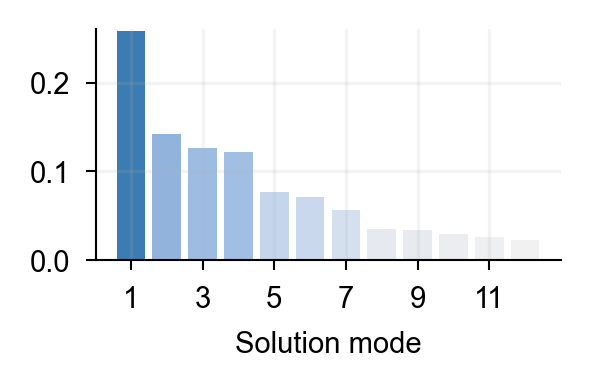

In [27]:
data = pis_df[pis_df['sub'] == 'grp']['omega'].to_list()
x_pos = np.arange(len(data))
cmap = cc.cm.CET_L12 # You can use any colormap you like
norm = mcolors.Normalize(vmin=min(data), vmax=max(data))

fig, ax = plt.subplots(1, 1, figsize=(2, 1), dpi=300)
ax.bar(x_pos, data, color=[cmap(norm(value)) for value in data])
ax.grid(alpha=0.15)
ax.set(
    ylim=[0, 0.26], xlabel='Solution mode',
    xticks=np.arange(0, len(data), 2), xticklabels=np.arange(1, len(data)+1, 2)
)
sns.despine(ax=ax)

fig.savefig(f'{folder}/desc-omega-plot.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/desc-omega-plot.png', transparent=True, dpi=300, bbox_inches='tight')

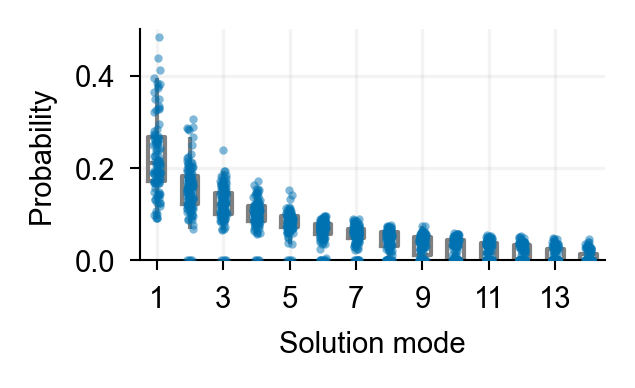

In [28]:
all_omegas = []
for sub, group in pis_df.groupby('sub'):
    omegas = group['omega'].to_numpy()
    all_omegas += [omegas]
    # break

max_num_modes = np.max([len(omegas) for omegas in all_omegas])
OMEGAs = np.zeros((len(all_omegas), max_num_modes))
for idx, omegas in enumerate(all_omegas):
    OMEGAs[idx, :len(omegas)] = omegas
    # break

fig, ax = plt.subplots(1, 1, figsize=(2, 1), dpi=300)
sns.boxplot(
    OMEGAs, 
    ax=ax,
    color='grey',
    fill=False,
    width=0.5,
    # whis=0,
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    OMEGAs, 
    ax=ax, 
    size=2,
    alpha=0.5,
    jitter=True,
    color=CUD_COLORS[0],
    label='Resample',
)

xmax = 13
ax.set(
    xlim=[-0.5, xmax+0.5], ylim=[0, 0.5], 
    xlabel='Solution mode', ylabel='Probability   ',
    xticks=np.arange(0, xmax, 2), xticklabels=np.arange(1, xmax+1, 2)
)
sns.despine(ax=ax)
ax.grid(alpha=0.15)

fig.savefig(f'{folder}/desc-omegas-plot.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/desc-omegas-plot.png', transparent=True, dpi=300, bbox_inches='tight')